# Toy Models of Superposition

This notebook includes the toy model training framework used to generate most of the results in the "Toy Models of Superposition" paper.

The main useful improvement over a basic PyTorch tiny autoencoder is the ability to batch train many models with varying sparsity at once, which is much more efficient than training them one at a time.

This notebook is designed to run in Google Colab's Python 3.7 environment.

In [1]:
#!pip install einops

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [119]:
@dataclass
class Config:
  n_features: int
  n_hidden: int
  head_d: int

  # We optimize n_instances models in a single training loop
  # to let us sweep over sparsity or importance curves 
  # efficiently.

  # We could potentially use torch.vmap instead.
  n_instances: int
 
class Model(nn.Module):
  def __init__(self, 
               config, 
               feature_probability: Optional[torch.Tensor] = None,
               importance: Optional[torch.Tensor] = None,               
               device='cuda'):
    super().__init__()
    self.config = config
    self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
    nn.init.xavier_normal_(self.W)
    self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))
    self.A = nn.Parameter(torch.empty((config.n_instances, config.n_hidden, config.head_d), device=device))
    nn.init.xavier_normal_(self.A)
    self.B = nn.Parameter(torch.empty((config.n_instances, config.n_hidden, config.head_d), device=device))
    nn.init.xavier_normal_(self.B)

    if feature_probability is None:
      feature_probability = torch.ones(())
    self.feature_probability = feature_probability.to(device)
    if importance is None:
      importance = torch.ones(())
    self.importance = importance.to(device)

  def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
    hidden = torch.einsum("...if,ifh->...ih", features, self.W)
    out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    out = out + self.b_final
    out = F.relu(out)
    return out

  def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W.device),
    )
    return batch

In [130]:
m = Model(Config(n_features = 7, n_hidden = 4, n_instances = 6, head_d = 3), feature_probability = torch.tensor(0.25), device=DEVICE)
b = m.generate_batch(4)
out_a = b[:4:2]
out_b = b[1:4:2]
b

tensor([[[0.0000, 0.0000, 0.4076, 0.0000, 0.0000, 0.0000, 0.4343],
         [0.5891, 0.0000, 0.0000, 0.0000, 0.8450, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5269, 0.0000, 0.0000],
         [0.5697, 0.6005, 0.9088, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.2709, 0.0464, 0.0000, 0.0000, 0.3700],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2540, 0.0000, 0.0000, 0.7626, 0.0000, 0.0843],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1740, 0.0000],
         [0.6574, 0.0000, 0.1867, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3613, 0.4941, 0.0000, 0.5414, 0.4690, 0.0000]],

        [[0.0000, 0.1703, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1403, 0.0000, 0.0000, 0.7761, 0.0000, 

In [141]:
pair_err(m.A, m.B, m.W, out_a, out_b)

torch.Size([2, 6, 6])
torch.Size([2, 6])


tensor(0.0204, device='mps:0', grad_fn=<NormBackward1>)

In [91]:
x = b[0].unsqueeze(0)
x.unsqueeze(-2).shape

torch.Size([1, 6, 1, 7])

In [205]:
def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def feature_association(f):
  assoc = torch.zeros((f, f), device=DEVICE)
  assoc[3, 4] = 1.0
  return assoc

def pair_err(A, B, W, x, y):
  """
  Pairwise error over aligned batch pairs using feature_association.
  x, y: tensors shaped [b, i, f]
  Returns a tensor broadcastable to [b, i, f] for reduction.
  """
  # Compute the outer product of the last dimensions of x and y, resulting in shape [b, i, f, f]
  # x: [b, i, f], y: [b, i, f]
  outer = x.unsqueeze(-1) * y.unsqueeze(-2)
  target = feature_association(x.shape[-1])  # [f, f]
  matches = outer * target
  target = matches.sum(dim=(-2, -1)) # [b, i]
  yWA = torch.einsum('bif, ifg, igh -> bih', y, W, A)
  xWB = torch.einsum('bif, ifg, igh -> bih', x, W, B)
  yWABWx = torch.matmul(yWA, xWB.transpose(-2, -1))  # [b, i, i]
  attn_pred = torch.diagonal(yWABWx, dim1=-2, dim2=-1)  # shape [b, i]
  # still need softmax here
  # Return the L2 norm of the difference between target and assoc
  return (target - attn_pred)**2

def optimize(model, 
             render=False, 
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      # Reconstruction loss (original)
      error = (model.importance*(batch.abs() - out)**2)
      recon_loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      # print('recon loss', recon_loss, recon_loss.shape)

      # Pairwise loss over batch pairs
      pairable = (n_batch // 2) * 2
      if pairable >= 2:
        # stepping by 2s in the batch dimension
        out_a = out[:pairable:2]
        out_b = out[1:pairable:2]
        pair_error = pair_err(model.A, model.B, model.W, out_a, out_b)
        pair_loss = einops.reduce(pair_error, 'b i -> i', 'mean').sum()
        # print('pair_loss', pair_loss, pair_loss.shape)
      else:
        pair_error = torch.zeros_like(out[:0])
        pair_loss = torch.tensor(0.0, device=out.device)

      loss = recon_loss + 50 * pair_loss
      loss.backward()
      opt.step()
    
      if hooks:
        hook_data = dict(model=model,
                         step=step, 
                         opt=opt,
                         error=error,
                         recon_loss=recon_loss,
                         pair_error=pair_error,
                         pair_loss=pair_loss,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )

In [123]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
elif torch.backends.mps.is_available():
  DEVICE = "mps"
else:
  DEVICE = 'cpu'

In [214]:
res_array = 0
def capture_stats(stats):
    global res_array
    if (stats['step']) == 0:
        res_array = []
    if (stats['step'] % 10) == 0:
        res_array.append((stats['step'], stats['recon_loss'].cpu().detach().numpy(), stats['pair_loss'].cpu().detach().numpy()))

## Introduction Figure

Reproducing a version of the figure from the introduction, although with a slightly different version of the code.

In [206]:
config = Config(
    n_features = 5,
    n_hidden = 2,
    head_d = 2,
    n_instances = 10,
)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = (20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

In [215]:
optimize(model, hooks = [capture_stats])

  0%|          | 0/10000 [00:00<?, ?it/s]

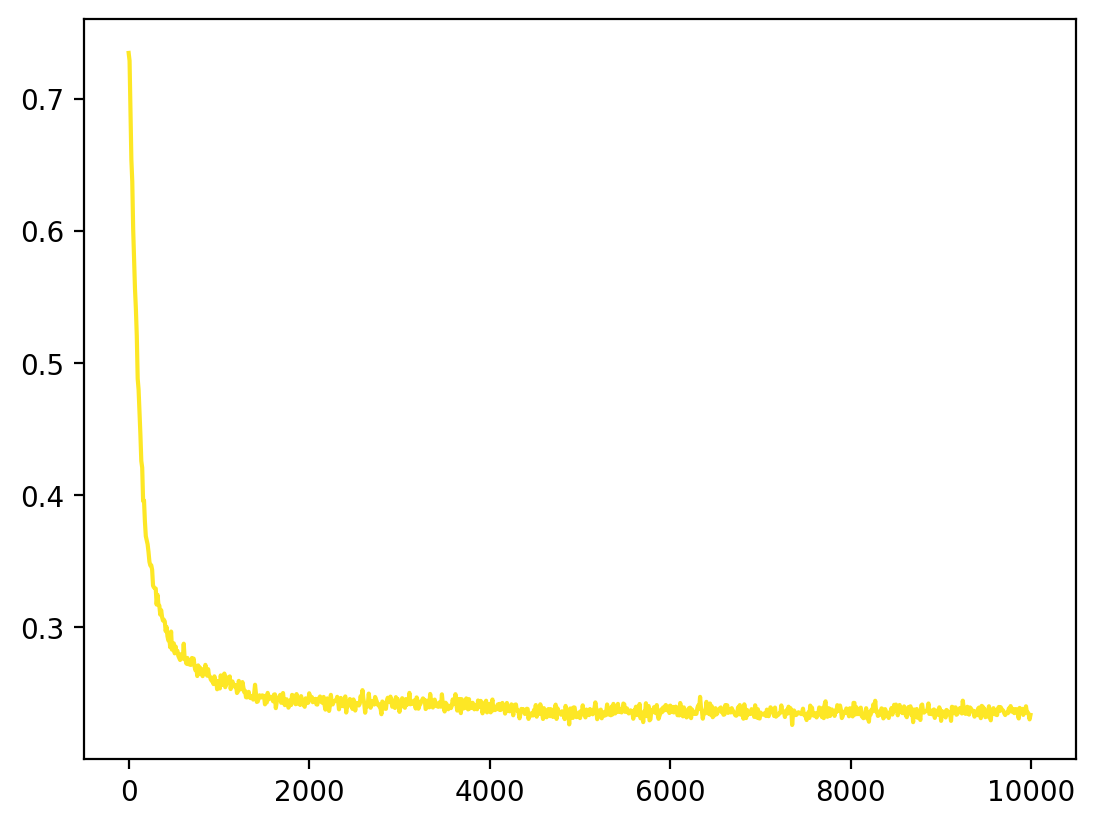

In [209]:
res = np.array(res_array)
plt.plot(res[:,0], res[:,1])

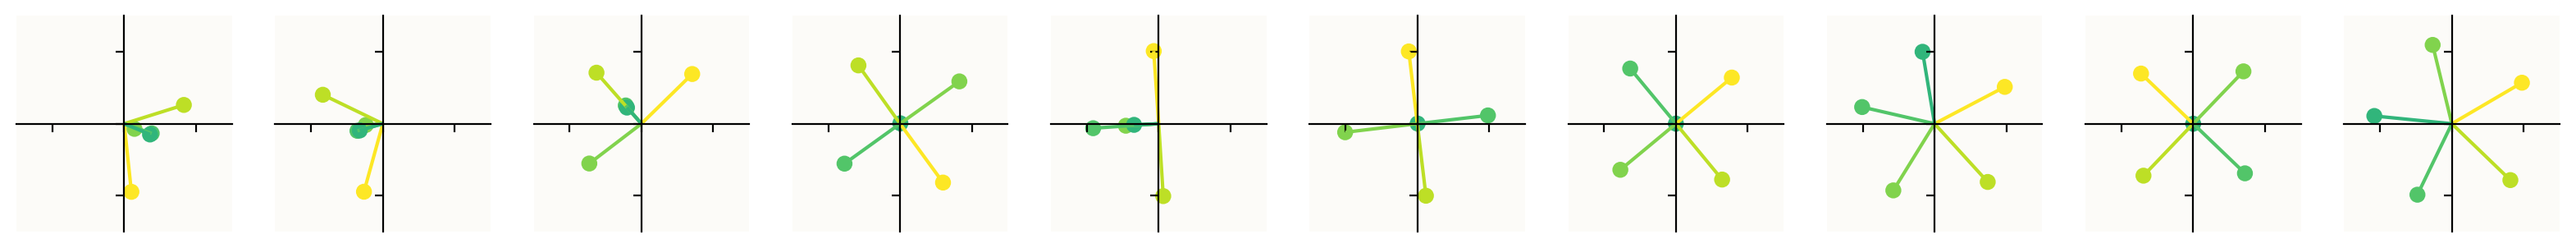

In [167]:
def plot_intro_diagram(model):
  from matplotlib import colors  as mcolors
  from matplotlib import collections  as mc
  cfg = model.config
  WA = model.W.detach()
  N = len(WA[:,0])
  sel = range(config.n_instances) # can be used to highlight specific sparsity levels
  plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(model.importance[0].cpu().numpy()))
  plt.rcParams['figure.dpi'] = 200
  fig, axs = plt.subplots(1,len(sel), figsize=(2*len(sel),2))
  for i, ax in zip(sel, axs):
      W = WA[i].cpu().detach().numpy()
      colors = [mcolors.to_rgba(c)
            for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
      ax.scatter(W[:,0], W[:,1], c=colors[0:len(W[:,0])])
      ax.set_aspect('equal')
      ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1), colors=colors))
      
      z = 1.5
      ax.set_facecolor('#FCFBF8')
      ax.set_xlim((-z,z))
      ax.set_ylim((-z,z))
      ax.tick_params(left = True, right = False , labelleft = False ,
                  labelbottom = False, bottom = True)
      for spine in ['top', 'right']:
          ax.spines[spine].set_visible(False)
      for spine in ['bottom','left']:
          ax.spines[spine].set_position('center')
  plt.show()

plot_intro_diagram(model)

# Visualizing features across varying sparsity

In [149]:
config = Config(
    n_features = 100,
    n_hidden = 20,
    head_d = 10,
    n_instances = 20,
)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (100 ** -torch.linspace(0, 1, config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = (20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

In [150]:
optimize(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

EinopsError:  Error while processing mean-reduction pattern "b i f -> i".
 Input tensor shape: torch.Size([]). Additional info: {}.
 Wrong shape: expected 3 dims. Received 0-dim tensor.

In [35]:
def render_features(model, which=np.s_[:]):
  cfg = model.config
  W = model.W.detach()
  W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

  interference = torch.einsum('ifh,igh->ifg', W_norm, W)
  interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0

  polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
  net_interference = (interference**2 * model.feature_probability[:, None, :]).sum(-1).cpu()
  norms = torch.linalg.norm(W, 2, dim=-1).cpu()

  WtW = torch.einsum('sih,soh->sio', W, W).cpu()

  # width = weights[0].cpu()
  # x = torch.cumsum(width+0.1, 0) - width[0]
  x = torch.arange(cfg.n_features)
  width = 0.9

  which_instances = np.arange(cfg.n_instances)[which]
  fig = make_subplots(rows=len(which_instances),
                      cols=2,
                      shared_xaxes=True,
                      vertical_spacing=0.02,
                      horizontal_spacing=0.1)
  for (row, inst) in enumerate(which_instances):
    fig.add_trace(
        go.Bar(x=x, 
              y=norms[inst],
              marker=dict(
                  color=polysemanticity[inst],
                  cmin=0,
                  cmax=1
              ),
              width=width,
        ),
        row=1+row, col=1
    )
    data = WtW[inst].numpy()
    fig.add_trace(
        go.Image(
            z=plt.cm.coolwarm((1 + data)/2, bytes=True),
            colormodel='rgba256',
            customdata=data,
            hovertemplate='''\
In: %{x}<br>
Out: %{y}<br>
Weight: %{customdata:0.2f}
'''            
        ),
        row=1+row, col=2
    )

  fig.add_vline(
    x=(x[cfg.n_hidden-1]+x[cfg.n_hidden])/2, 
    line=dict(width=0.5),
    col=1,
  )
    
  # fig.update_traces(marker_size=1)
  fig.update_layout(showlegend=False, 
                    width=600,
                    height=100*len(which_instances),
                    margin=dict(t=0, b=0))
  fig.update_xaxes(visible=False)
  fig.update_yaxes(visible=False)
  return fig

In [210]:
fig = render_features(model, np.s_[::2])
fig.update_layout()

# Feature geometry

In [13]:
config = Config(
    n_features = 200,
    n_hidden = 20,
    n_instances = 20,
)

model = Model(
    config=config,
    device=DEVICE,
    # For this experiment, use constant importance.

    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = (20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

In [14]:
optimize(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
fig = px.line(
    x=1/model.feature_probability[:, 0].cpu(),
    y=(model.config.n_hidden/(torch.linalg.matrix_norm(model.W.detach(), 'fro')**2)).cpu(),
    log_x=True,
    markers=True,
)
fig.update_xaxes(title="1/(1-S)")
fig.update_yaxes(title=f"m/||W||_F^2")

In [16]:
@torch.no_grad()
def compute_dimensionality(W):
  norms = torch.linalg.norm(W, 2, dim=-1) 
  W_unit = W / torch.clamp(norms[:, :, None], 1e-6, float('inf'))

  interferences = (torch.einsum('eah,ebh->eab', W_unit, W)**2).sum(-1)

  dim_fracs = (norms**2/interferences)
  return dim_fracs.cpu()

In [17]:
dim_fracs = compute_dimensionality(model.W)

In [18]:
fig = go.Figure()

density = model.feature_probability[:, 0].cpu()
W = model.W.detach()

for a,b in [(1,2), (2,3), (2,5), (2,6), (2,7)]:
    val = a/b
    fig.add_hline(val, line_color="purple", opacity=0.2, annotation=dict(text=f"{a}/{b}"))

for a,b in [(5,6), (4,5), (3,4), (3,8), (3,12), (3,20)]:
    val = a/b
    fig.add_hline(val, line_color="blue", opacity=0.2, annotation=dict(text=f"{a}/{b}", x=0.05))

for i in range(len(W)):
    fracs_ = dim_fracs[i]
    N = fracs_.shape[0]
    xs = 1/density
    if i!= len(W)-1:
        dx = xs[i+1]-xs[i]
    fig.add_trace(
        go.Scatter(
            x=1/density[i]*np.ones(N)+dx*np.random.uniform(-0.1,0.1,N),
            y=fracs_,
            marker=dict(
                color='black',
                size=1,
                opacity=0.5,
            ),
            mode='markers',
        )
    )

fig.update_xaxes(
    type='log', 
    title='1/(1-S)',
    showgrid=False,
)
fig.update_yaxes(
    showgrid=False
)
fig.update_layout(showlegend=False)